# 2<sup>η</sup> ΕΡΓΑΣΤΗΡΙΑΚΗ ΑΣΚΗΣΗ

## Ανάλυση Κοινωνικής Δομής σε Τεχνητές και Πραγματικές Σύνθετες Τοπολογίες Δικτύων
<p style=text-align:justify>Στην παρούσα άσκηση θα αναλυθούν τεχνητές και πραγματικές τοπολογίες σύνθετων δικτύων με βάση τις μετρικές που χρησιμοποιήθηκαν στην προηγούμενη άσκηση και κάποιες τεχνικές που έχουν ως στόχο την εύρεση κοινωνικής δομής. Συγκεκριμένα, θα χρησιμοποιηθούν και θα συγκριθούν διάφοροι αλγόριθμοι εντοπισμού κοινοτήτων σε γράφους δικτύων που προκύπτουν από πραγματικά δεδομένα καθώς και στους συνθετικούς γράφους της πρώτης εργαστηριακής άσκησης.</p>

In [ ]:
%matplotlib inline
%pip install pyamg

import matplotlib
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import csv
from sklearn.cluster import SpectralClustering
from networkx.algorithms.community.centrality import girvan_newman
import itertools
import networkx.algorithms.community as nx_comm
from tqdm import tqdm
import time
from networkx.algorithms.community import greedy_modularity_communities

## Α. Μελέτη πραγματικών τοπολογιών
<p style=text-align:justify>Στο παρόν ερώτημα θα μελετήσετε και θα αποκτήσετε αίσθηση της τοπολογικής δομής πραγματικών δικτύων. Πιο συγκεκριμένα, για τις τοπολογίες που φαίνονται στον <b>πίνακα 1</b>, να βρεθούν και να δειχθούν:</p>
<ol>
    <li>Η κατανομή του βαθμού κόμβου και ο μέσος βαθμός κάθε τοπολογίας.</li>
    <li>Η κατανομή του συντελεστή ομαδοποίησης κόμβου και ο μέσος συντελεστής ομαδοποίησης κάθε τοπολογίας.</li>
    <li>Η κατανομή της κεντρικότητας εγγύτητας και η μέση κεντρικότητα εγγύτητας κάθε τοπολογίας.</li>
</ol>
<p style=text-align:justify>Να συγκριθούν τα αποτελέσματα σε σχέση με αυτά των συνθετικών τοπολογιών. Να χαρακτηρίσετε τον τύπο κάθε μίας από τις πραγματικές τοπολογίες με βάση τους τύπους δικτύων που εξετάστηκαν στην πρώτη εργαστηριακή άσκηση.</p>

<table style=width:100%>
    <caption>Πίνακας <b>1</b>: Πραγματικές τοπολογίες</a></caption>
<tr>
    <th style=text-align:left>Τοπολογία</th>
    <th style=text-align:left>Αρχείο</th>
    <th style=text-align:left>Περιγραφή</th>
</tr>
<tr>
    <td style=text-align:left>American College Football</td>
    <td style=text-align:left><a style=text-decoration:none href='http://www-personal.umich.edu/~mejn/netdata/football.zip'>football.gml</a></td>
    <td style=text-align:left><p style=text-align:justify> The file <b>football.gml</b> contains the network of American football games between Division IA colleges during regular season Fall 2000, as compiled by M. Girvan and M. Newman. The nodes have values that indicate to which conferences they belong.</p>
    </td>
</tr>  
<tr>
    <td style=text-align:left>Game of Thrones - season 5</td>
    <td style=text-align:left><a style=text-decoration:none href='https://networkofthrones.wordpress.com/the-series/season-5/'>GoT</a></td>
    <td style=text-align:left><p style=text-align:justify> The season 5 <b>GoT</b> network represents the interactions between the characters of Game of Thrones in season 5. The season 5 network has 118 nodes (characters) and 394 weighted edges, corresponding to 5,139 interactions. Data can be found here: <a style=text-decoration:none href='https://raw.githubusercontent.com/mathbeveridge/gameofthrones/master/data/got-s5-edges.csv'>GoT_data</a></p>
</tr> 
<tr>
    <td style=text-align:left>email-Eu-core</td>
    <td style=text-align:left><a style=text-decoration:none href='https://snap.stanford.edu/data/email-Eu-core.html'>email-eu-core</a></td>
    <td style=text-align:left><p style=text-align:justify> The network <b>email-Eu-core</b> was generated using email data from a large European research institution. There is an edge (u, v) in the network if person u sent person v at least one email. The e-mails only represent communication between institution members (the core) and the dataset does not contain incoming messages from or outgoing messages to the rest of the world. The dataset also contains "ground-truth" community memberships of the nodes. Each individual belongs to exactly one of 42 departments at the research institute. </p>
</tr> 
    
</table>

### Παραγωγή συνθετικών τοπολογιών
<p>Προσοχή! Τα δίκτυα που θα παράξετε θα πρέπει να είναι συνδεδεμένα.</p>

In [45]:
n=80
d=4
M=300
R=0.25
p=0.3
k=4
seedno=5
random.seed(seedno)

REG = nx.watts_strogatz_graph(n, d, 0, seed=seedno)
RGER = nx.gnm_random_graph(n, M, seed=seedno)
RGGB = nx.gnp_random_graph(n, p, seed=seedno)
RGG = nx.random_geometric_graph(n, R, seed=seedno)
SF = nx.barabasi_albert_graph(n, k, seed=seedno)
SW = nx.watts_strogatz_graph(n, d, p, seed=seedno)

In [46]:
synthetic = [REG, RGER, RGGB, RGG, SF, SW]

for graph in synthetic:
    if not nx.is_connected(graph):
        print(f"{graph} is not connected!")

### Εισαγωγή και οπτικοποίηση πραγματικών τοπολογιών

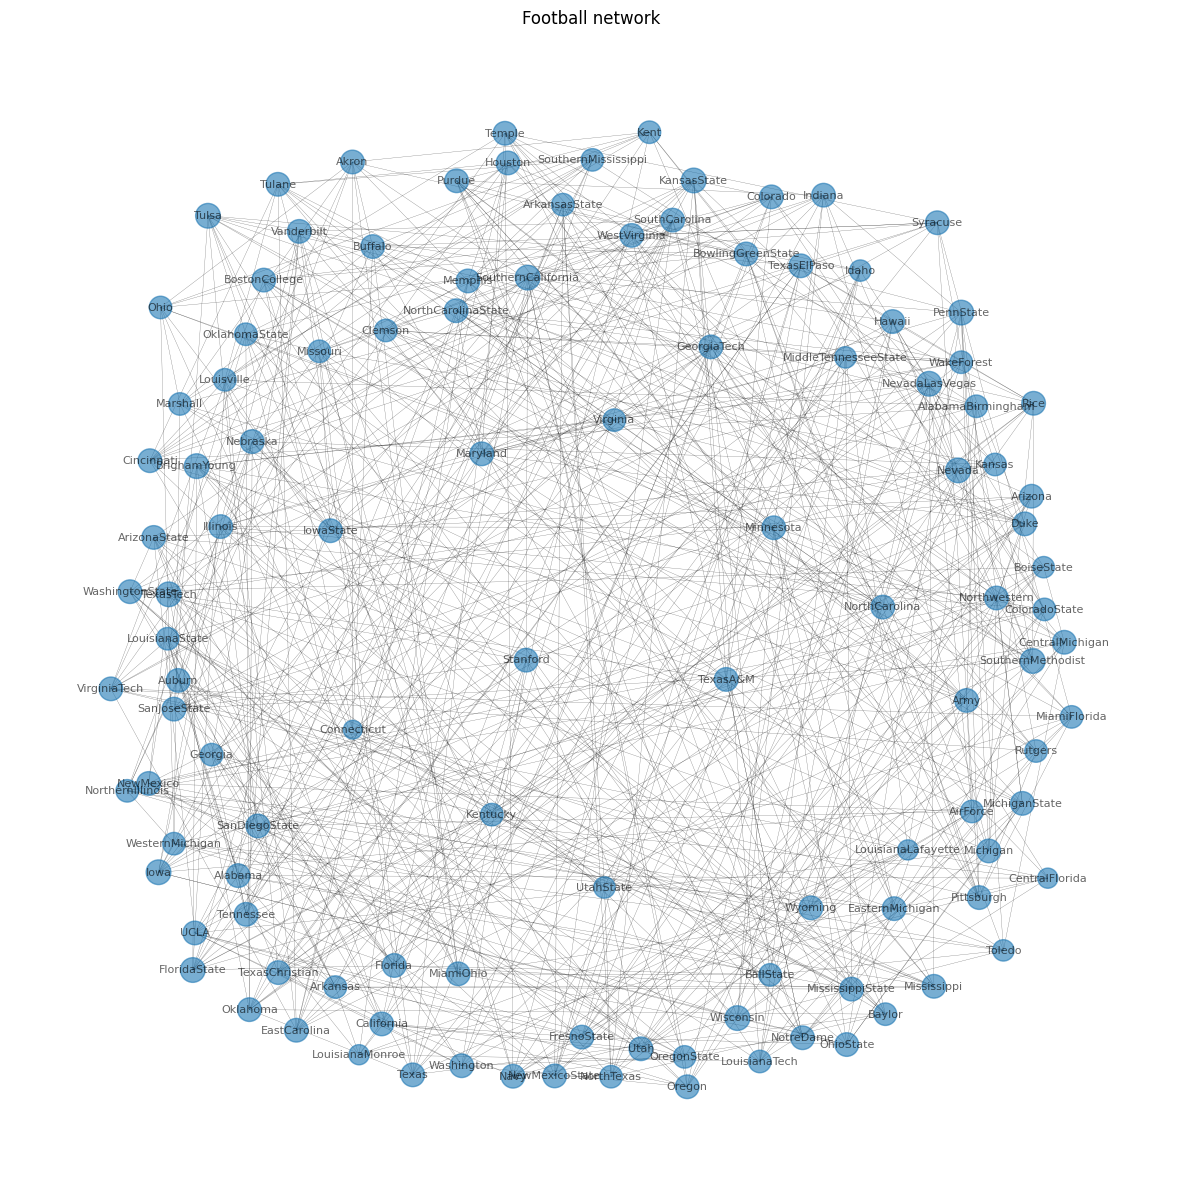

In [47]:
# football network
football = nx.read_gml(r"resources/football.gml")

plt.figure(figsize=(15,15))
plt.title("Football network")
pos = nx.spring_layout(football, k=1, iterations=15)
nx.draw(football, pos, node_size=[v*3000 for v in nx.degree_centrality(football).values()], with_labels=True, font_size=8, width=0.2, alpha=0.6)

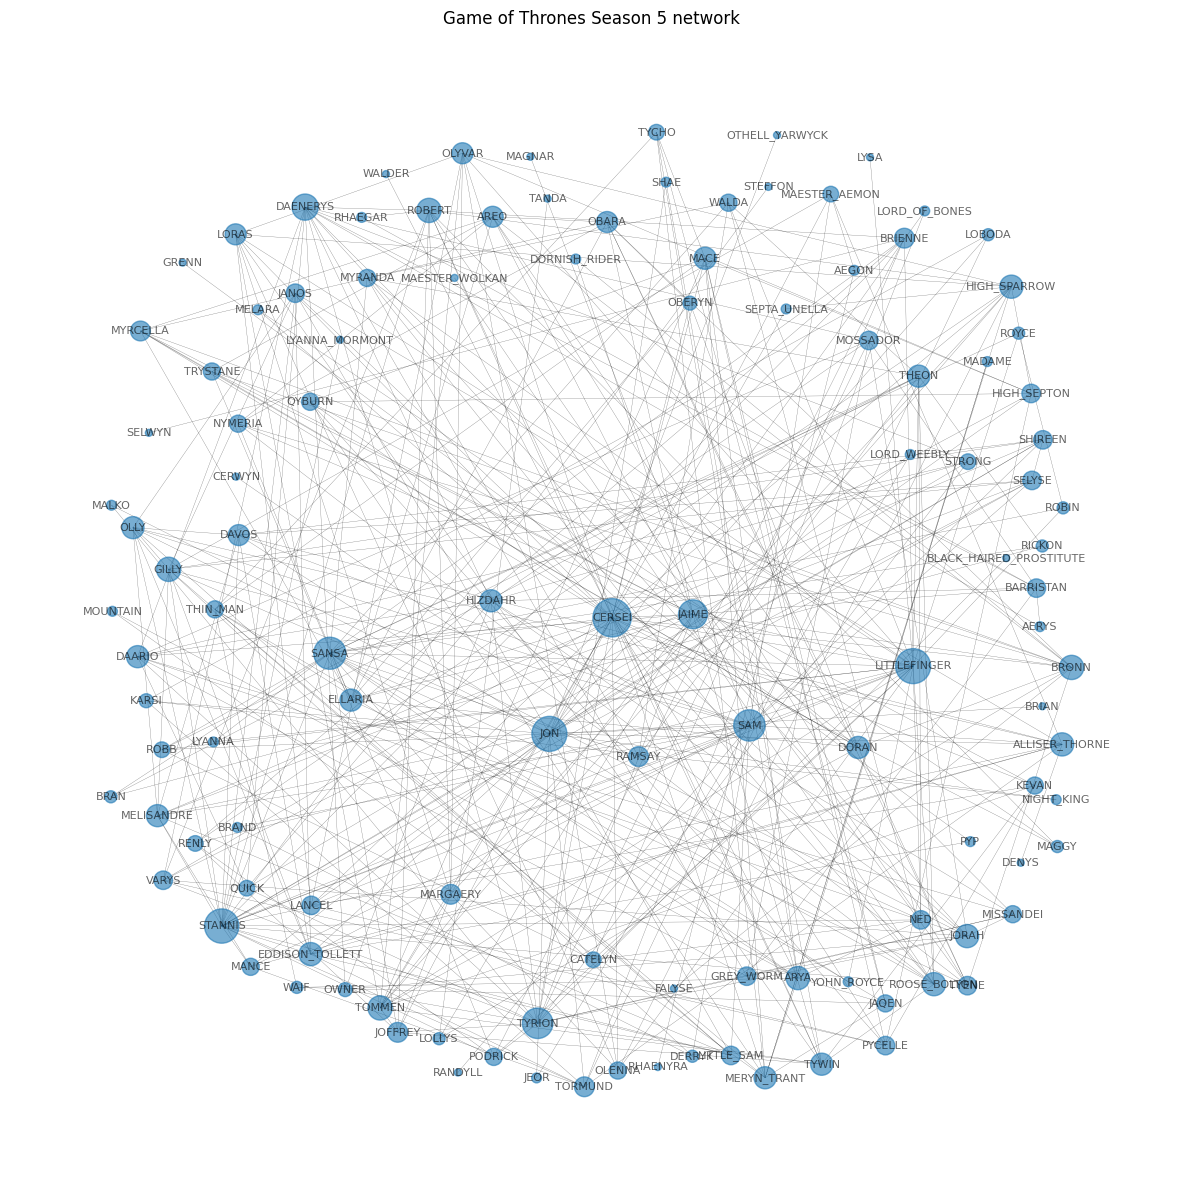

In [48]:
# game of thrones network
got = nx.Graph()
with open('resources/got_s5.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    next(csv_reader)
    for row in csv_reader:
        got.add_edge(row[0],row[1])
        line_count += 1

plt.figure(figsize=(15,15))
plt.title("Game of Thrones Season 5 network")
pos = nx.spring_layout(got, k=1, iterations=15)
nx.draw(got, pos, node_size=[v*3000 for v in nx.degree_centrality(got).values()], with_labels=True, font_size=8, width=0.2, alpha=0.6)

#### Προσοχή! Θα μελετήσετε τη μεγαλύτερη συνδεδεμένη συνιστώσα του δικτύου email-Eu-core, αφού πρώτα αφαιρέσετε τα self-loops. Μπορείτε να κάνετε χρήση των συναρτήσεων connected_components, subgraph, remove_edges_from του networkx.

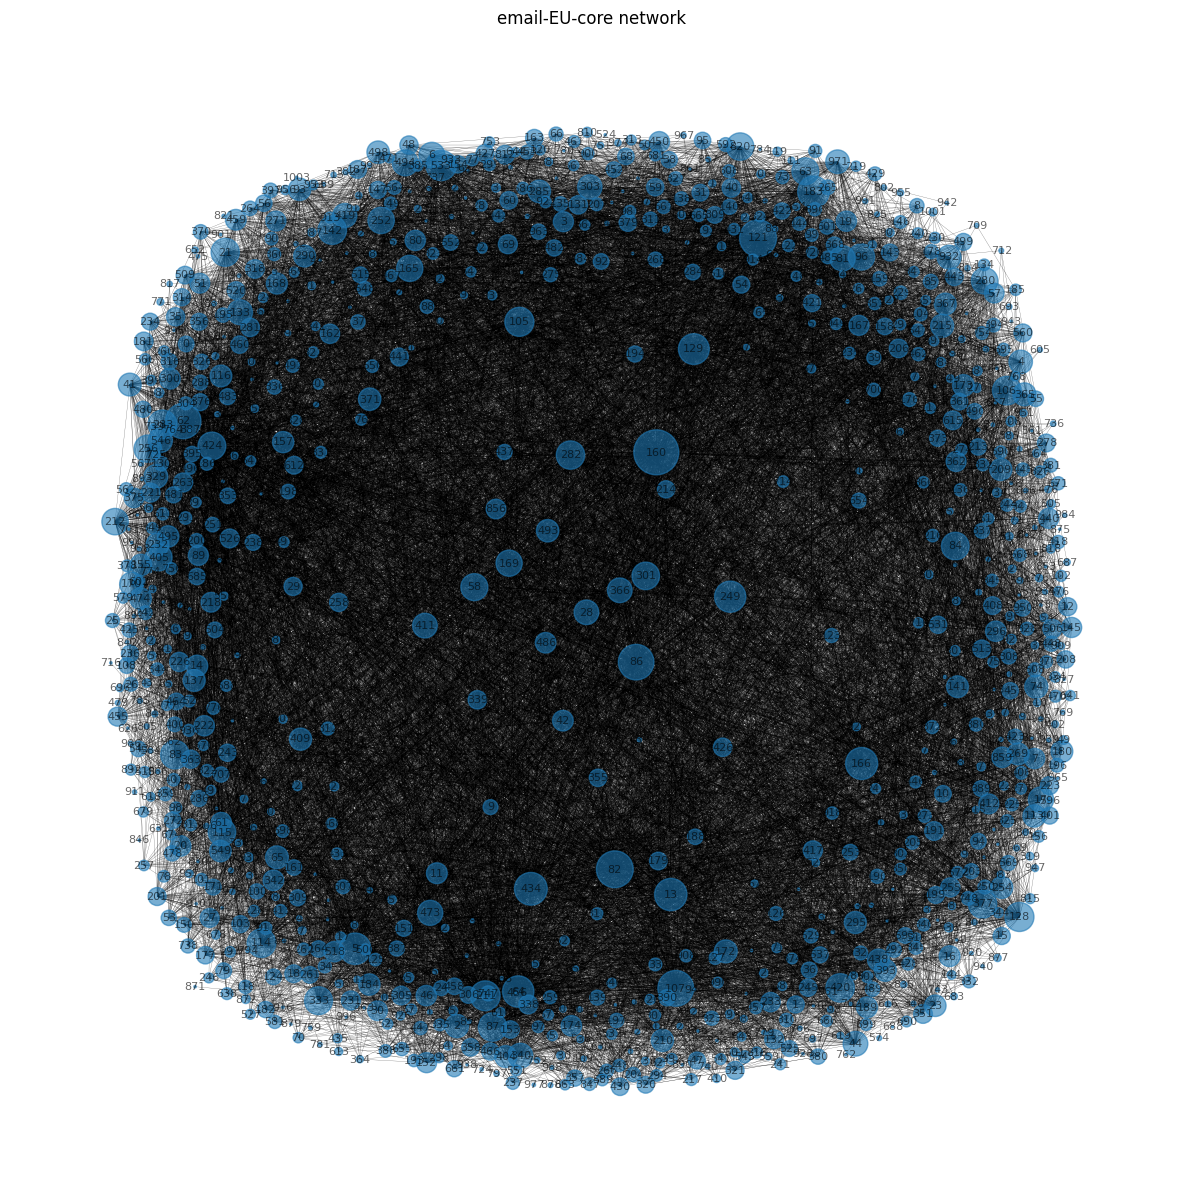

In [61]:
# email-Eu-core network
eu = nx.read_edgelist("resources/email-Eu-core.txt", create_using=nx.Graph())

eu.remove_edges_from(nx.selfloop_edges(eu))
largest_cc = max(nx.connected_components(eu), key=len)
eu = eu.subgraph(largest_cc)

plt.figure(figsize=(15,15))
plt.title("email-EU-core network")
pos = nx.spring_layout(eu, k=1, iterations=15)
nx.draw(eu, pos, node_size=[v*3000 for v in nx.degree_centrality(eu).values()], with_labels=True, font_size=8, width=0.2, alpha=0.6)

### Μελέτη βαθμού κόμβου για πραγματικές και συνθετικές τοπολογίες

Average degree of Regural Graph is: 4.0
Average degree of Random Graph ER is: 7.5
Average degree of Random Graph GB is: 23.95
Average degree of Random Geometric Graph is: 11.25
Average degree of Scale Free Graph is: 7.6
Average degree of Small World Graph is: 4.0
Average degree of Football is: 10.660869565217391
Average degree of Game of Thrones is: 6.65546218487395
Average degree of email-EU-core is: 32.5841784989858


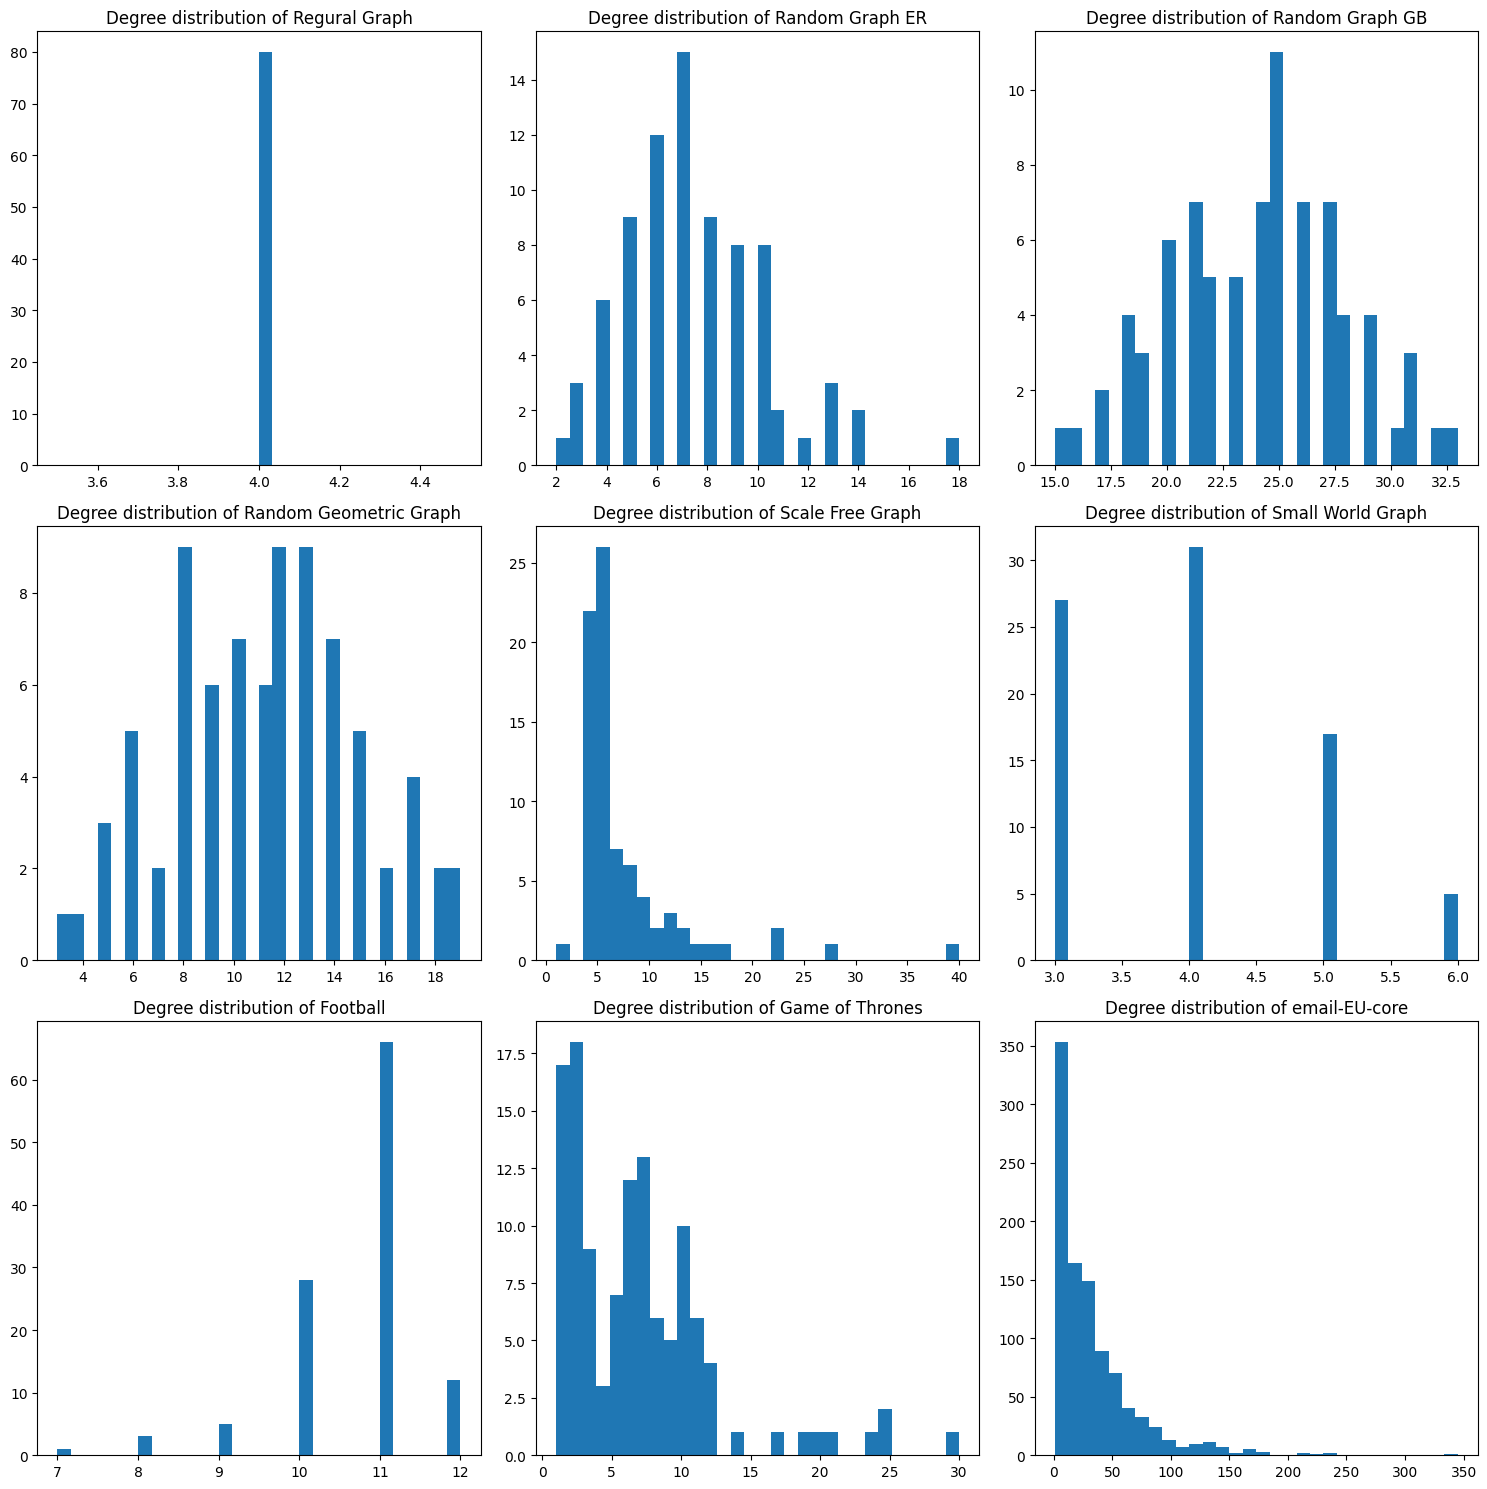

In [50]:
real = [football, got, eu]
graphs = synthetic + real
labels = ["Regural Graph", "Random Graph ER", "Random Graph GB", "Random Geometric Graph", "Scale Free Graph", "Small World Graph", "Football", "Game of Thrones", "email-EU-core"]
names = dict(zip(graphs, labels))

fig, ax = plt.subplots(3, 3, figsize=(15,15))

for i in range(len(graphs)):
    degrees = nx.degree(graphs[i])
    values = []
    for degree in degrees:
        values.append(degree[1])
    ax[int(i/3), int(i%3)].hist(values, bins=30)
    ax[int(i/3), int(i%3)].set_title(f"Degree distribution of {names[graphs[i]]}")
    
    print(f"Average degree of {names[graphs[i]]} is: {np.mean(values)}")

plt.tight_layout()
plt.show()

### Μελέτη συντελεστή ομαδοποίησης για πραγματικές και συνθετικές τοπολογίες

Average clustering coefficient of Regural Graph is: 0.5
Average clustering coefficient of Random Graph ER is: 0.08497775916893564
Average clustering coefficient of Random Graph GB is: 0.3031095412714132
Average clustering coefficient of Random Geometric Graph is: 0.6825788363897883
Average clustering coefficient of Scale Free Graph is: 0.22922761606585135
Average clustering coefficient of Small World Graph is: 0.16708333333333333
Average clustering coefficient of Football is: 0.40321601104209803
Average clustering coefficient of Game of Thrones is: 0.5744036387164707
Average clustering coefficient of email-EU-core is: 0.4070504475195386


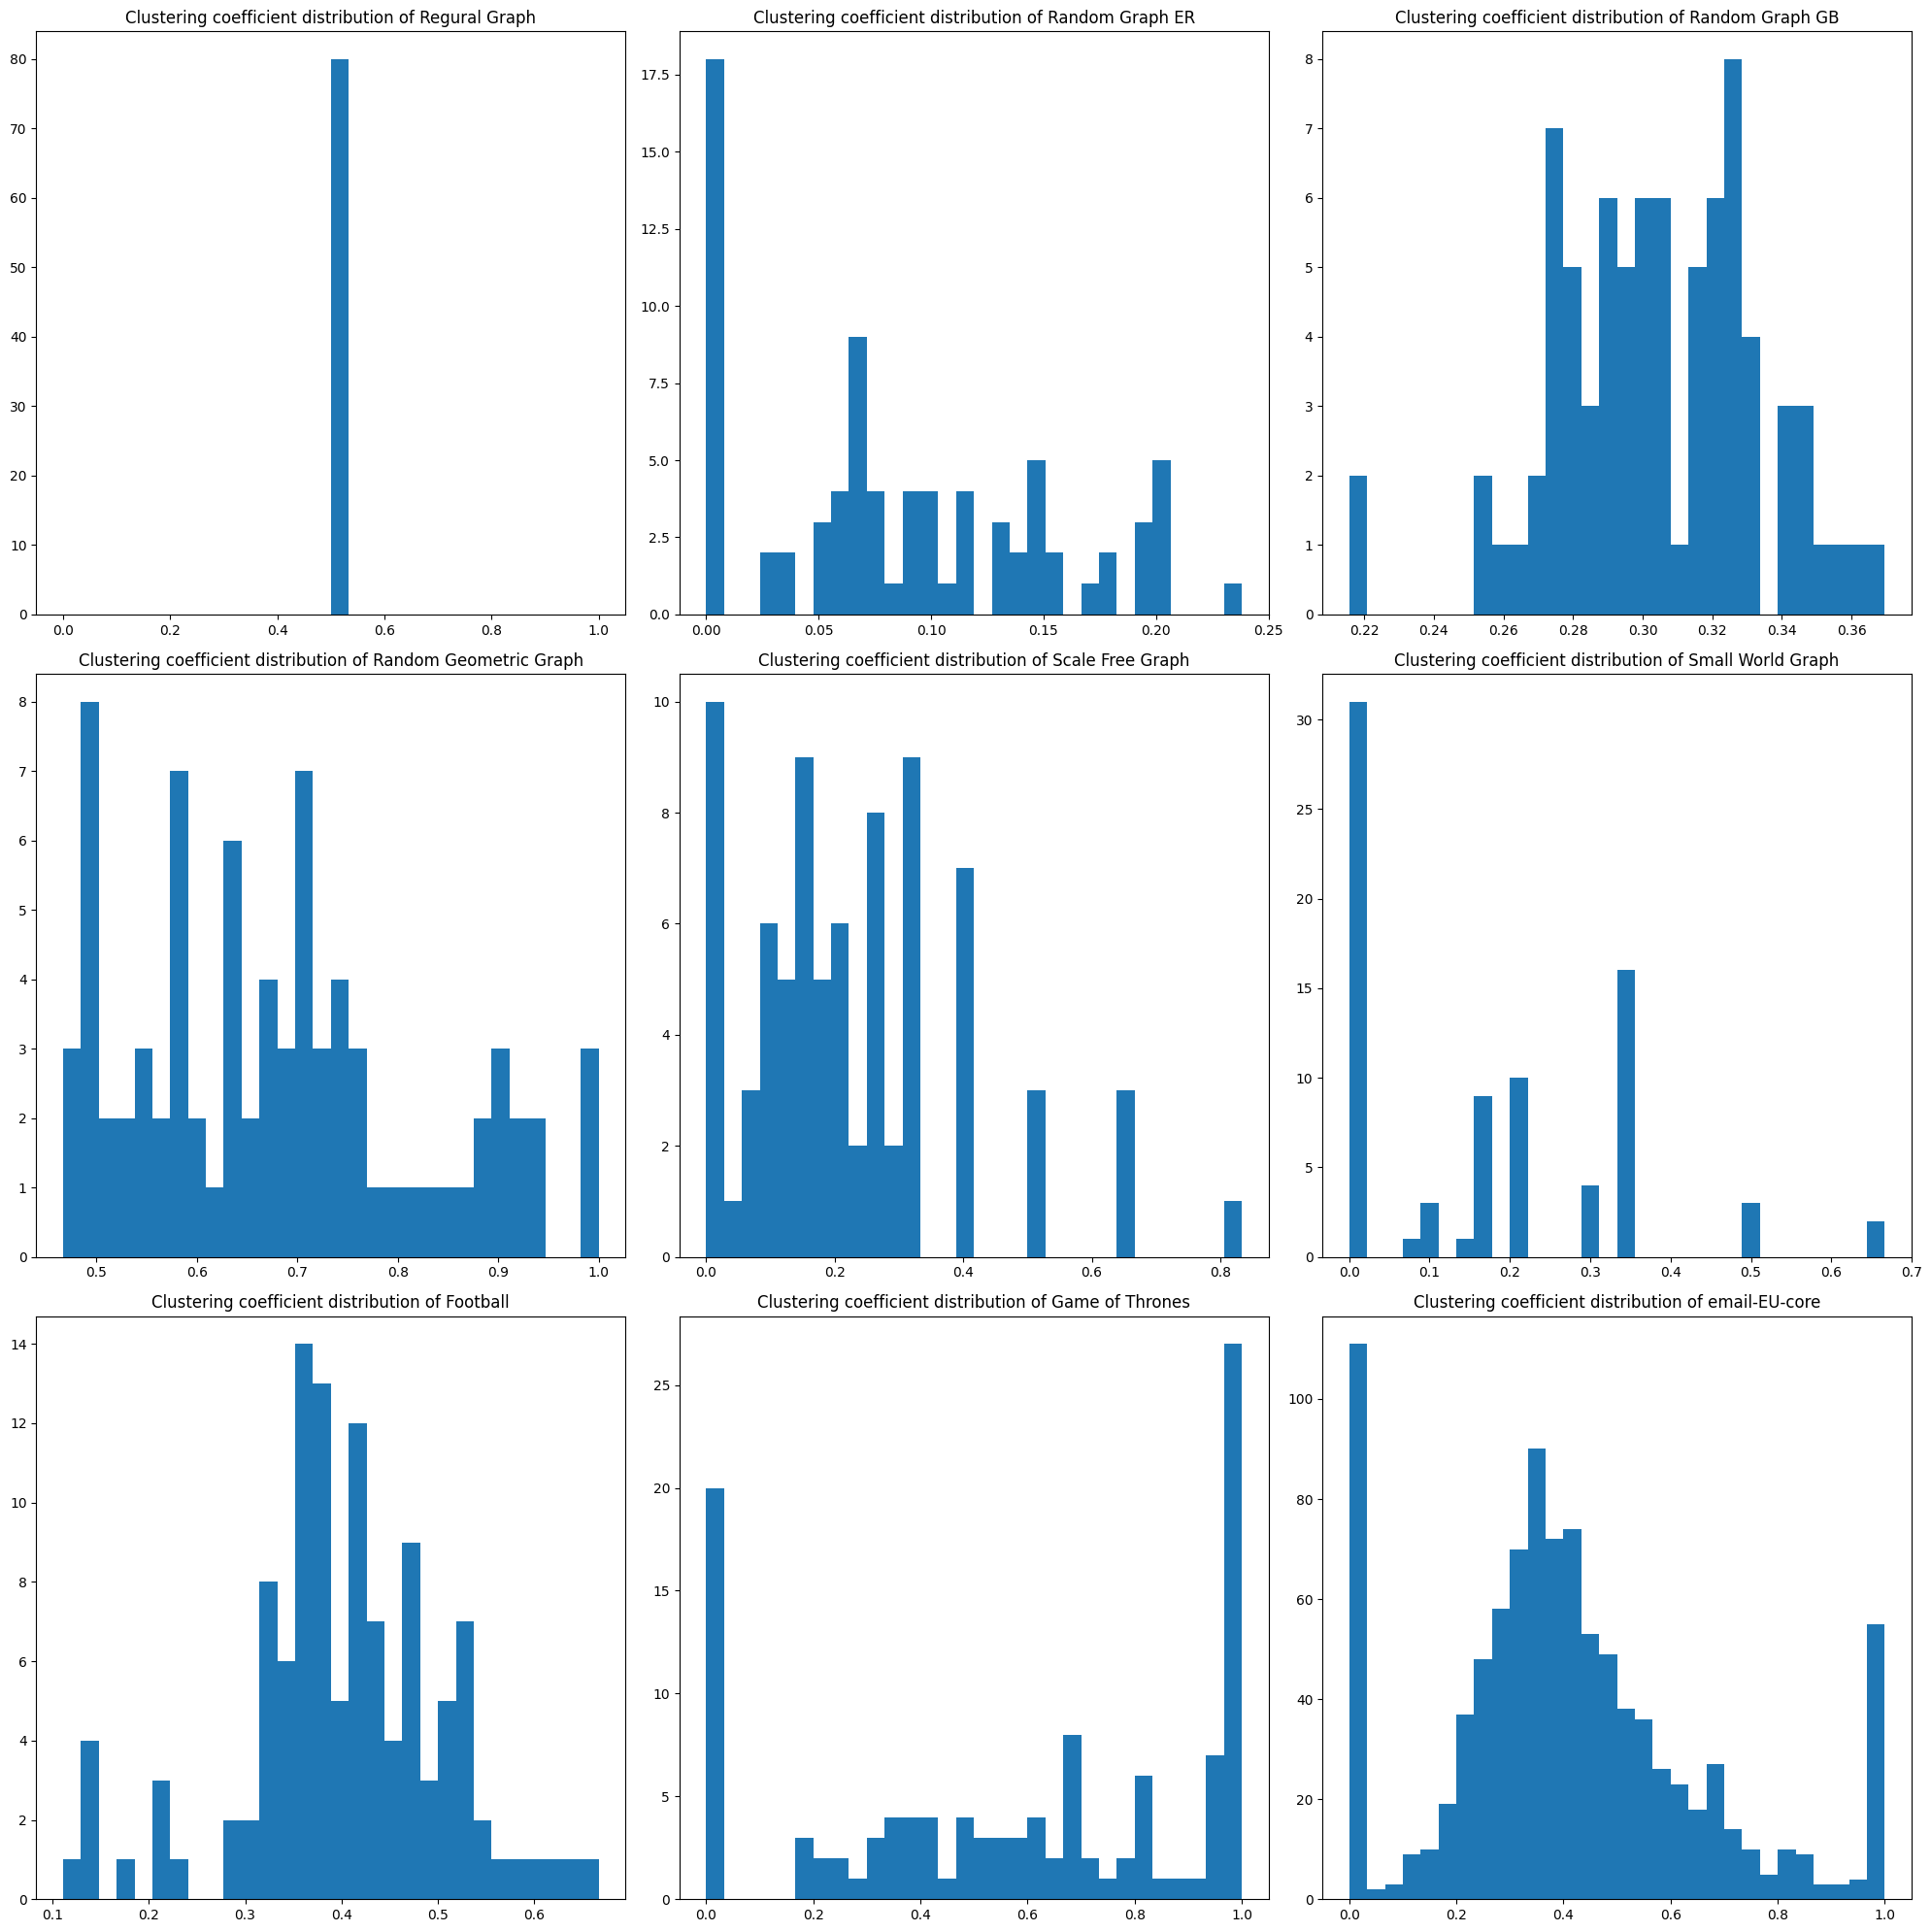

In [51]:
fig, ax = plt.subplots(3, 3, figsize=(20,20))

for i in range(len(graphs)):
    ccs = nx.clustering(graphs[i]).values()
    ax[int(i/3), int(i%3)].hist(ccs, bins=30)
    ax[int(i/3), int(i%3)].set_title(f"Clustering coefficient distribution of {names[graphs[i]]}")
    
    print(f"Average clustering coefficient of {names[graphs[i]]} is: {np.mean(list(ccs))}")

plt.tight_layout()
plt.show()

### Μελέτη κεντρικότητας εγγύτητας για πραγματικές και συνθετικές τοπολογίες

Average closeness centrality of Regural Graph is: 0.09634146341463413
Average closeness centrality of Random Graph ER is: 0.4242297800918761
Average closeness centrality of Random Graph GB is: 0.5897420498110714
Average closeness centrality of Random Geometric Graph is: 0.320088016052558
Average closeness centrality of Scale Free Graph is: 0.4464453837879834
Average closeness centrality of Small World Graph is: 0.26914269896354603
Average closeness centrality of Football is: 0.39931907825186225
Average closeness centrality of Game of Thrones is: 0.31905170483140755
Average closeness centrality of email-EU-core is: 0.39446404120869627


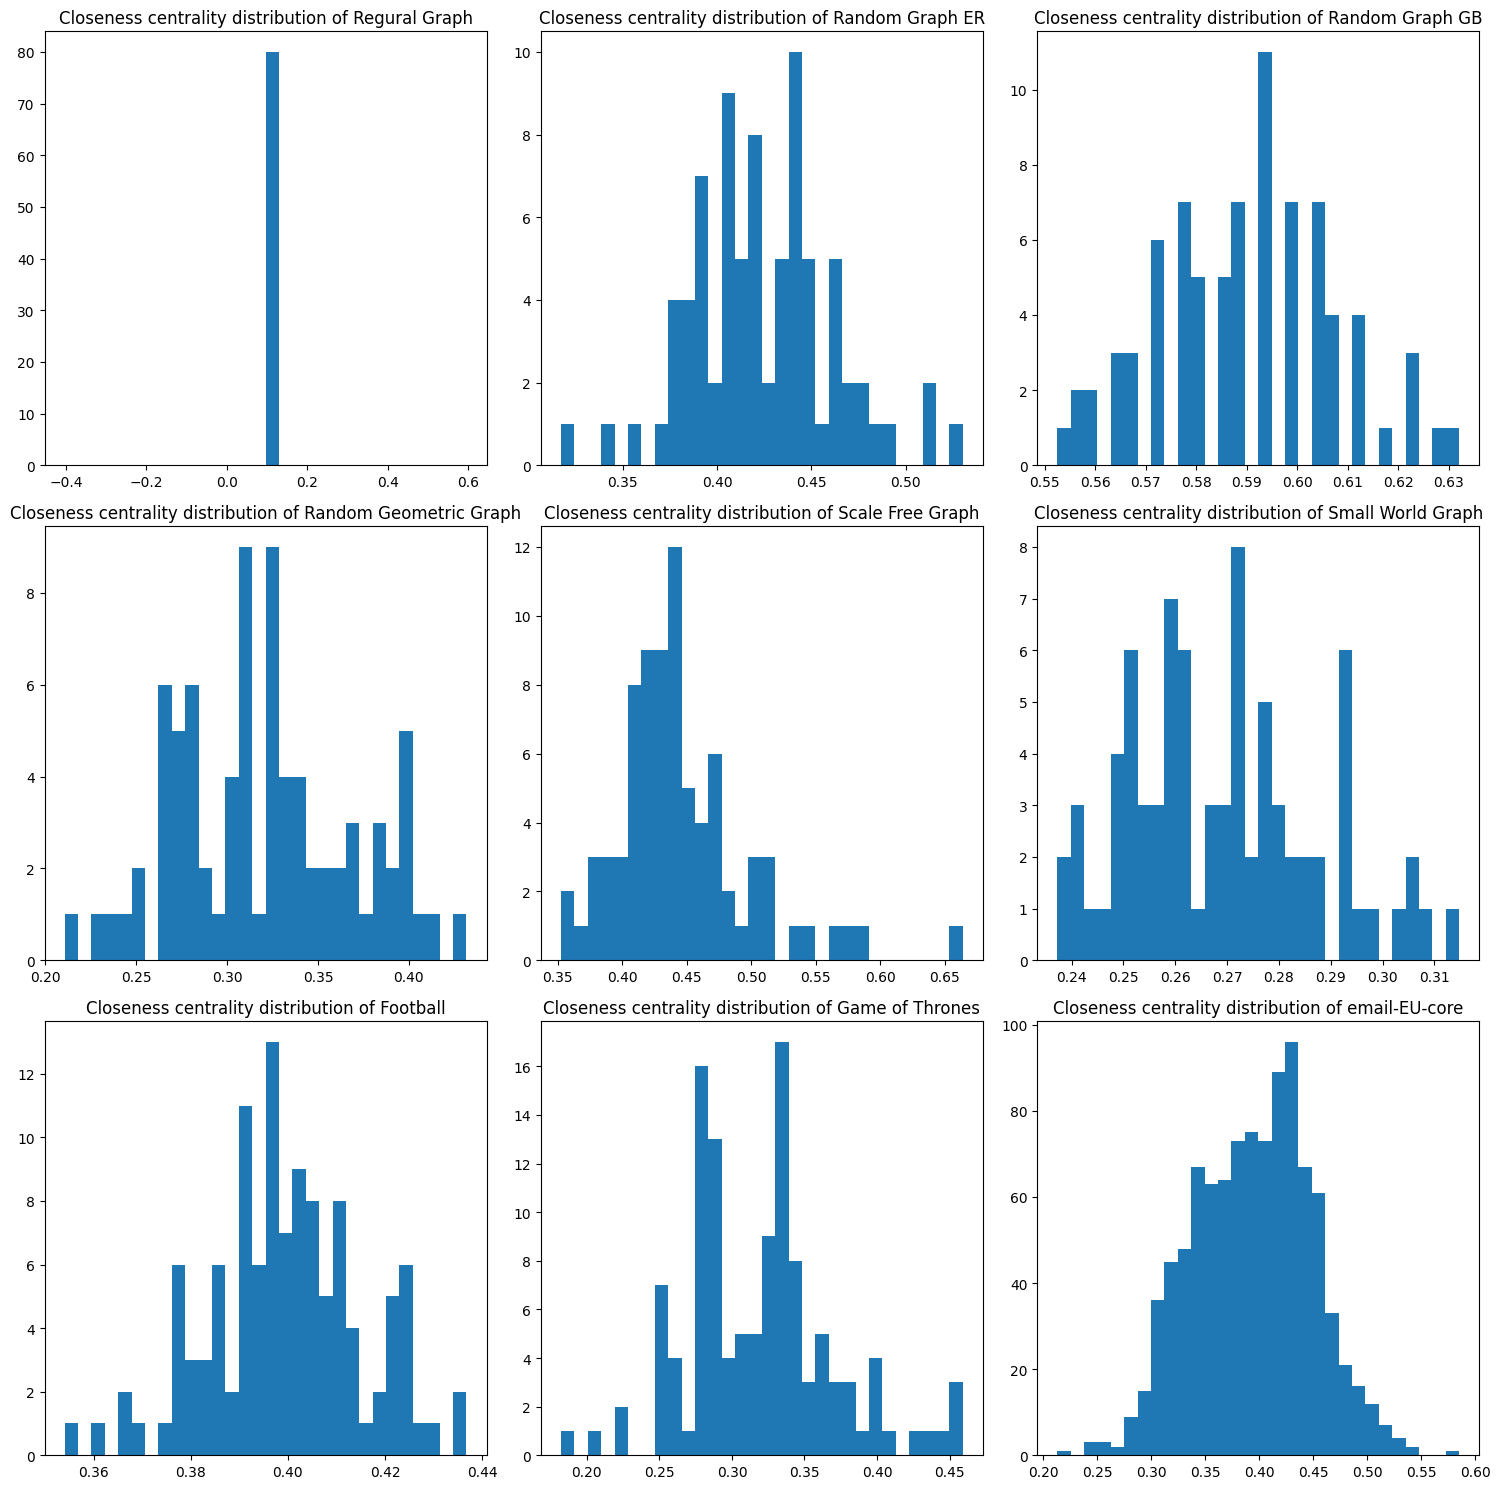

In [52]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))

for i in range(len(graphs)):
    values = nx.closeness_centrality(graphs[i]).values()
    ax[int(i/3), int(i%3)].hist(values, bins=30)
    ax[int(i/3), int(i%3)].set_title(f"Closeness centrality distribution of {names[graphs[i]]}")
    
    print(f"Average closeness centrality of {names[graphs[i]]} is: {np.mean(list(values))}")

plt.tight_layout()
plt.show()

## B. Εξοικείωση με τα εργαλεία εντοπισμού κοινοτήτων
<ol>
<li>Χρησιμοποιώντας τις συναρτήσεις του <b>πίνακα 2</b> για κάθε <u>πραγματικό</u> (<b>πίνακας 1</b>) και <u>συνθετικό</u> (από την <b>άσκηση 1</b>) δίκτυο:</p>
<ol>
    <li>να οπτικοποιηθούν οι κοινότητες που προκύπτουν από την κάθε μέθοδο,</li>
    <li>να γίνουν οι απαραίτητοι σχολιασμοί (π.χ: σύγκριση του αριθμού των κοινοτήτων που υπολογίζει ο κάθε αλγόριθμος).</li>
</ol>
<p>Για την οπτικοποίηση, να επισημανθεί διαφορετικά κάθε κοινότητα, π.χ. με διαφορετικό χρώμα.</p>
<p style=text-align:justify>Στην περίπτωση των συνθετικών δικτύων, να πραγματοποιηθούν συγκρίσεις και μεταξύ των διαφορετικών τύπων τοπολογιών. Για παράδειγμα, στην περίπτωση του τυχαίου γεωμετρικού γράφου, υπάρχει διαισθητικά μία κοινότητα γύρω από κάθε κόμβο που δημιουργείται με βάση τις αποστάσεις του τελευταίου από τους υπόλοιπους κόμβους του δικτύου. Στην περίπτωση των scale-free δικτύων, είναι πιθανό να σχηματίζονται κοινότητες γύρω από τους κόμβους με μεγάλο βαθμό.</p>
<li>Για κάθε αλγόριθμο εντοπισμού κοινοτήτων και για κάθε τοπολογία αξιολογήστε την ποιότητα της διαμέρισης με τις μετρικές performance και modularity (<a style=text-decoration:none href='https://networkx.org/documentation/stable/reference/algorithms/community.html#module-networkx.algorithms.community.quality'>measuring_partitions</a>). Για την μετρική performance, θα χρησιμοποιήσετε την συνάρτηση partition_quality του networkx.</li>
<li>Για την μεγαλύτερη συνδεδεμένη συνιστώσα του email-Eu-core, να συγκρίνετε την ground-truth διαμέριση που δίνεται στο αρχείο Email-Eu-core-department-labels.txt με τις διαμερίσεις που προκύπτουν από τις εξεταζόμενες μεθόδους ως προς το πλήθος των παραγόμενων κοινοτήτων και ως προς τις μετρικές performance και modularity. </li>
<li>Για την παρακολούθηση του χρόνου εκτέλεσης της υλοποίησής σας, μπορείτε να χρησιμοποιήσετε τις βιωλιοθήκες <a style=text-decoration:none href='https://tqdm.github.io/'>tqdm</a> και <a style=text-decoration:none href='https://docs.python.org/3/library/time.html'>time</a> . Στο σχολιασμό σας να λάβετε υπόψη το trade-off της ποιότητας της διαμέρισης και του χρόνου εκτέλεσης των εξεταζόμενων αλγορίθμων. </li>
</ol>

<table style=float:left;width:70%>
    <caption>Πίνακας <b>2</b>: Συναρτήσεις εντοπισμού κοινοτήτων</caption>
    <tr>
        <th style=text-align:left> Μέθοδος εντοπισμού κοινοτήτων</th>
        <th style=text-align:left>Συνάρτηση</th>
    </tr>
    <tr>
        <td style=text-align:left>Newman-Girvan</td>
        <td style=text-align:left><a style=text-decoration:none                               href='https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html'>girvan_newman</a></td>
    </tr>
    <tr>
        <td style=text-align:left>Spectral Clustering</td>
        <td style=text-align:left><a style=text-decoration:none href='http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html'>SpectralClustering</a></td>
    </tr>
    <tr>
        <td style=text-align:left>Modularity Maximization</td>
        <td style=text-align:left><a style=text-decoration:none                               href='https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html'>greedy_modularity_communities</a></td>
    </tr>
</table>
    

<p style=text-align:justify>Προτού εφαρμόσετε τις συναρτήσεις εντοπισμού κοινοτήτων μελετήστε προσεκτικά την <b>είσοδο που απαιτούν καθώς και τη μορφή εξόδου που παράγουν.</b></p>

In [53]:
# Χρησιμοποιήστε την συνάρτηση conv2int για να μετατρέψετε τα labels των κόμβων στις πραγματικές τοπολογίες σε integers
def conv2int(G,start_value):
    nG = nx.convert_node_labels_to_integers(G,first_label=start_value)
    G_mapping=dict(enumerate(G.nodes,0))
    return nG, G_mapping

### Ορισμός χρωμάτων για την οπτικοποίηση των κοινοτήτων

In [54]:
# insert colors for nodes
from matplotlib import colors as mcolors
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

### Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Newman-Girvan
<p>Παράξτε τις διαμερίσεις που προκύπτουν από την μέθοδο Newman-Girvan. Ελέγξτε τις διαμερίσεις που έχουν μέχρι και 50 κοινότητες.</p> 
<p> Επιλέξτε τις διαμερίσεις με το 1) μεγαλύτερο modularity score και 2) performance score για κάθε πραγματικό και συνθετικό δίκτυο.</p>

In [55]:
ng_modularities = {}
ng_performances = {}

start = time.time()

for graph in tqdm(graphs):
    clustering = girvan_newman(graph)
    limited = itertools.takewhile(lambda c: len(c) <= 50, clustering)

    max_modularity = (-1, None)
    max_performance = (-1, None)

    for communities in limited:
        modularity = nx_comm.modularity(graph, communities)
        if modularity > max_modularity[0]:
            max_modularity = (modularity, communities)

        performance = nx_comm.partition_quality(graph, communities)[1]
        if performance > max_performance[0]:
            max_performance = (performance, communities)

    ng_modularities[graph] = max_modularity
    ng_performances[graph] = max_performance

    print(f"- For {names[graph]}:")
    print(f"Max modularity score: {np.format_float_positional(max_modularity[0], 3)}")
    print(f"Max performance score: {np.format_float_positional(max_performance[0], 3)}")

end = time.time()
print(f"Time elapsed: {np.format_float_positional(end-start, 3)} sec.")

 11%|█         | 1/9 [00:00<00:05,  1.35it/s]

- For Regural Graph:
Max modularity score: 0.725
Max performance score: 0.97


 22%|██▏       | 2/9 [00:05<00:19,  2.82s/it]

- For Random Graph ER:
Max modularity score: 0.211
Max performance score: 0.922


 33%|███▎      | 3/9 [00:28<01:14, 12.35s/it]

- For Random Graph GB:
Max modularity score: 0.032
Max performance score: 0.686


 44%|████▍     | 4/9 [00:31<00:43,  8.74s/it]

- For Random Geometric Graph:
Max modularity score: 0.597
Max performance score: 0.929


 56%|█████▌    | 5/9 [00:35<00:28,  7.01s/it]

- For Scale Free Graph:
Max modularity score: 0.136
Max performance score: 0.917


 67%|██████▋   | 6/9 [00:36<00:14,  4.92s/it]

- For Small World Graph:
Max modularity score: 0.574
Max performance score: 0.967


 78%|███████▊  | 7/9 [00:45<00:12,  6.27s/it]

- For Football:
Max modularity score: 0.6
Max performance score: 0.958


 89%|████████▉ | 8/9 [00:49<00:05,  5.36s/it]

- For Game of Thrones:
Max modularity score: 0.668
Max performance score: 0.964


100%|██████████| 9/9 [21:09<00:00, 141.09s/it]

- For email-EU-core:
Max modularity score: 0.001
Max performance score: 0.139
Time elapsed: 1269.819 sec.


### Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Spectral Clustering
Προσοχή! Για την επιλογή της τιμής της παραμέτρου που αφορά στην διάσταση του projection subspace (n_clusters) της συνάρτησης SpectralClustering, θα πρέπει να λάβετε υπόψη το μέγεθος |V| του εκάστοτε δικτύου.
<p>Να εξετάσετε τις διαμερίσεις που προκύπτουν για n_clusters$=2,...,|V|$. Να επιλέξετε για οπτικοποίηση τις διαμερίσεις με το 1) μεγαλύτερο modularity score και 2) performance score για κάθε πραγματικό και συνθετικό δίκτυο.</p>

In [70]:
sc_modularities = {}
sc_performances = {}

start = time.time()

for graph in tqdm(graphs):
    v = graph.number_of_nodes()
    nodes = list(graph.nodes())
    adjacency = nx.to_numpy_array(graph)

    max_modularity = (-1, None)
    max_performance = (-1, None)

    for i in range(2, 51):
        clustering = SpectralClustering(n_clusters=i, affinity='precomputed', eigen_solver='amg').fit(adjacency)

        cluster = ()
        for x in range(i):
            cluster += (set(),)
        for x in range(v):
            cluster[clustering.labels_[x]].add(nodes[x])

        modularity = nx_comm.modularity(graph, cluster)
        if modularity > max_modularity[0]:
            max_modularity = (modularity, cluster)

        performance = nx_comm.partition_quality(graph, cluster)[1]
        if performance > max_performance[0]:
            max_performance = (performance, cluster)

    sc_modularities[graph] = max_modularity
    sc_performances[graph] = max_performance

    print(f"- For {names[graph]}:")
    print(f"Max modularity score: {np.format_float_positional(max_modularity[0], 3)}")
    print(f"Max performance score: {np.format_float_positional(max_performance[0], 3)}")

end = time.time()
print(f"Time elapsed: {np.format_float_positional(end-start, 3)} sec.")

 11%|█         | 1/9 [00:20<02:43, 20.38s/it]

- For Regural Graph:
Max modularity score: 0.725
Max performance score: 0.974


 22%|██▏       | 2/9 [00:31<01:43, 14.78s/it]

- For Random Graph ER:
Max modularity score: 0.276
Max performance score: 0.915


 33%|███▎      | 3/9 [00:38<01:09, 11.51s/it]

- For Random Graph GB:
Max modularity score: 0.12
Max performance score: 0.730


 44%|████▍     | 4/9 [00:44<00:46,  9.24s/it]

- For Random Geometric Graph:
Max modularity score: 0.602
Max performance score: 0.936


 56%|█████▌    | 5/9 [00:50<00:31,  7.93s/it]

- For Scale Free Graph:
Max modularity score: 0.268
Max performance score: 0.912


 67%|██████▋   | 6/9 [00:56<00:21,  7.30s/it]

- For Small World Graph:
Max modularity score: 0.557
Max performance score: 0.968


 78%|███████▊  | 7/9 [01:03<00:14,  7.43s/it]

- For Football:
Max modularity score: 0.602
Max performance score: 0.958


 89%|████████▉ | 8/9 [01:12<00:07,  7.87s/it]

- For Game of Thrones:
Max modularity score: 0.665
Max performance score: 0.947


100%|██████████| 9/9 [02:32<00:00, 16.90s/it]

- For email-EU-core:
Max modularity score: 0.341
Max performance score: 0.872
Time elapsed: 152.148 sec.


### Εντοπισμός κοινοτήτων σε συνθετικά και πραγματικά δίκτυα με τη μέθοδο Modularity Maximization
Για την διαμέριση που θα προκύψει σε κάθε συνθετικό και πραγματικό δίκτυο, να υπολογίσετε το modularity score και το performance score.

In [ ]:
mm_modularities = {}
mm_performances = {}

start = time.time()

for graph in tqdm(graphs):
    clustering = greedy_modularity_communities(graph)

    max_modularity = (nx_comm.modularity(graph, clustering), clustering)
    max_performance = (nx_comm.partition_quality(graph, clustering)[1], clustering)

    mm_modularities[graph] = max_modularity
    mm_performances[graph] = max_performance

    print(f"- For {names[graph]}:")
    print(f"Max modularity score: {np.format_float_positional(max_modularity[0], 3)}")
    print(f"Max performance score: {np.format_float_positional(max_performance[0], 3)}")

end = time.time()
print(f"Time elapsed: {np.format_float_positional(end-start, 3)} sec.")

 22%|██▏       | 2/9 [00:00<00:00, 19.27it/s]

- For Regural Graph:
Max modularity score: 0.673
Max performance score: 0.801
- For Random Graph ER:
Max modularity score: 0.284
Max performance score: 0.759
- For Random Graph GB:
Max modularity score: 0.124
Max performance score: 0.652
- For Random Geometric Graph:
Max modularity score: 0.585
Max performance score: 0.829


 78%|███████▊  | 7/9 [00:00<00:00, 13.26it/s]

- For Scale Free Graph:
Max modularity score: 0.270
Max performance score: 0.794
- For Small World Graph:
Max modularity score: 0.563
Max performance score: 0.900
- For Football:
Max modularity score: 0.556
Max performance score: 0.868
- For Game of Thrones:
Max modularity score: 0.660
Max performance score: 0.83


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]

- For email-EU-core:
Max modularity score: 0.347
Max performance score: 0.708
Time elapsed: 9.597 sec.


#### Οπτικοποίηση κοινοτήτων American College Football

#### Οπτικοποίηση κοινοτήτων Game of Thrones

#### Οπτικοποίηση κοινοτήτων email-Eu-core (να οπτικοποιηθεί και η ground-truth διαμέριση)

#### Οπτικοποίηση κοινοτήτων REG

#### Οπτικοποίηση κοινοτήτων RGER

#### Οπτικοποίηση κοινοτήτων RGG

#### Οπτικοποίηση κοινοτήτων SW

#### Οπτικοποίηση κοινοτήτων SF